In [1]:
import gym
import torch
import random
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque

In [2]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')


def plot_weight_distribution(model):
    plt.figure(figsize=(12, 4), dpi=400)

    for name, param in model.named_parameters():
        if "weight" in name:
            sns.histplot(param.data.cpu().numpy().flatten(), bins=100, kde=True, label=name)

    plt.title("Weight Distribution of DQN")
    plt.xlabel("Weight Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [3]:
# DQN 네트워크 정의
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        return self.fc3(x)


# DQN 에이전트 정의
class DQNAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, epsilon=1, lr=0.0001, batch_size=64, memory_size=100000,
                 target_update=10):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.target_update = target_update
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # DQN 및 Target 네트워크 초기화
        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()
        self.steps = 0

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)

        tau = max(0.1, self.epsilon)  # Ensure temperature does not reach zero
        probabilities = torch.nn.functional.softmax(q_values / tau, dim=1).cpu().numpy().flatten()
        action = np.random.choice(self.action_dim, p=probabilities)

        return action

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        q_values = self.policy_net(states).gather(1, actions).squeeze(1)
        next_q_values = self.target_net(next_states).max(1)[0]
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        loss = self.loss_fn(q_values, target_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self, min_epsilon=0.01, decay_rate=0.995):
        self.epsilon = max(min_epsilon, self.epsilon * decay_rate)

In [4]:
# 환경 설정
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim)
agent.policy_net.apply(initialize_weights)
agent.target_net.apply(initialize_weights)
episodes = 1000
rewards_log = []

# 학습 실행
for episode in tqdm(range(episodes)):
    state, _ = env.reset()
    total_reward = 0

    for _ in range(500):
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward
        if done:
            break

    agent.decay_epsilon()
    rewards_log.append(total_reward)

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\asas4\anaconda3\envs\ETC\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\asas4\AppData\Local\Temp\ipykernel_34140\2728147899.py:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  states = torch.FloatTensor(states).to(self.device)
100%|██████████| 1000/1000 [09:05<00:00,  1.83it/s]


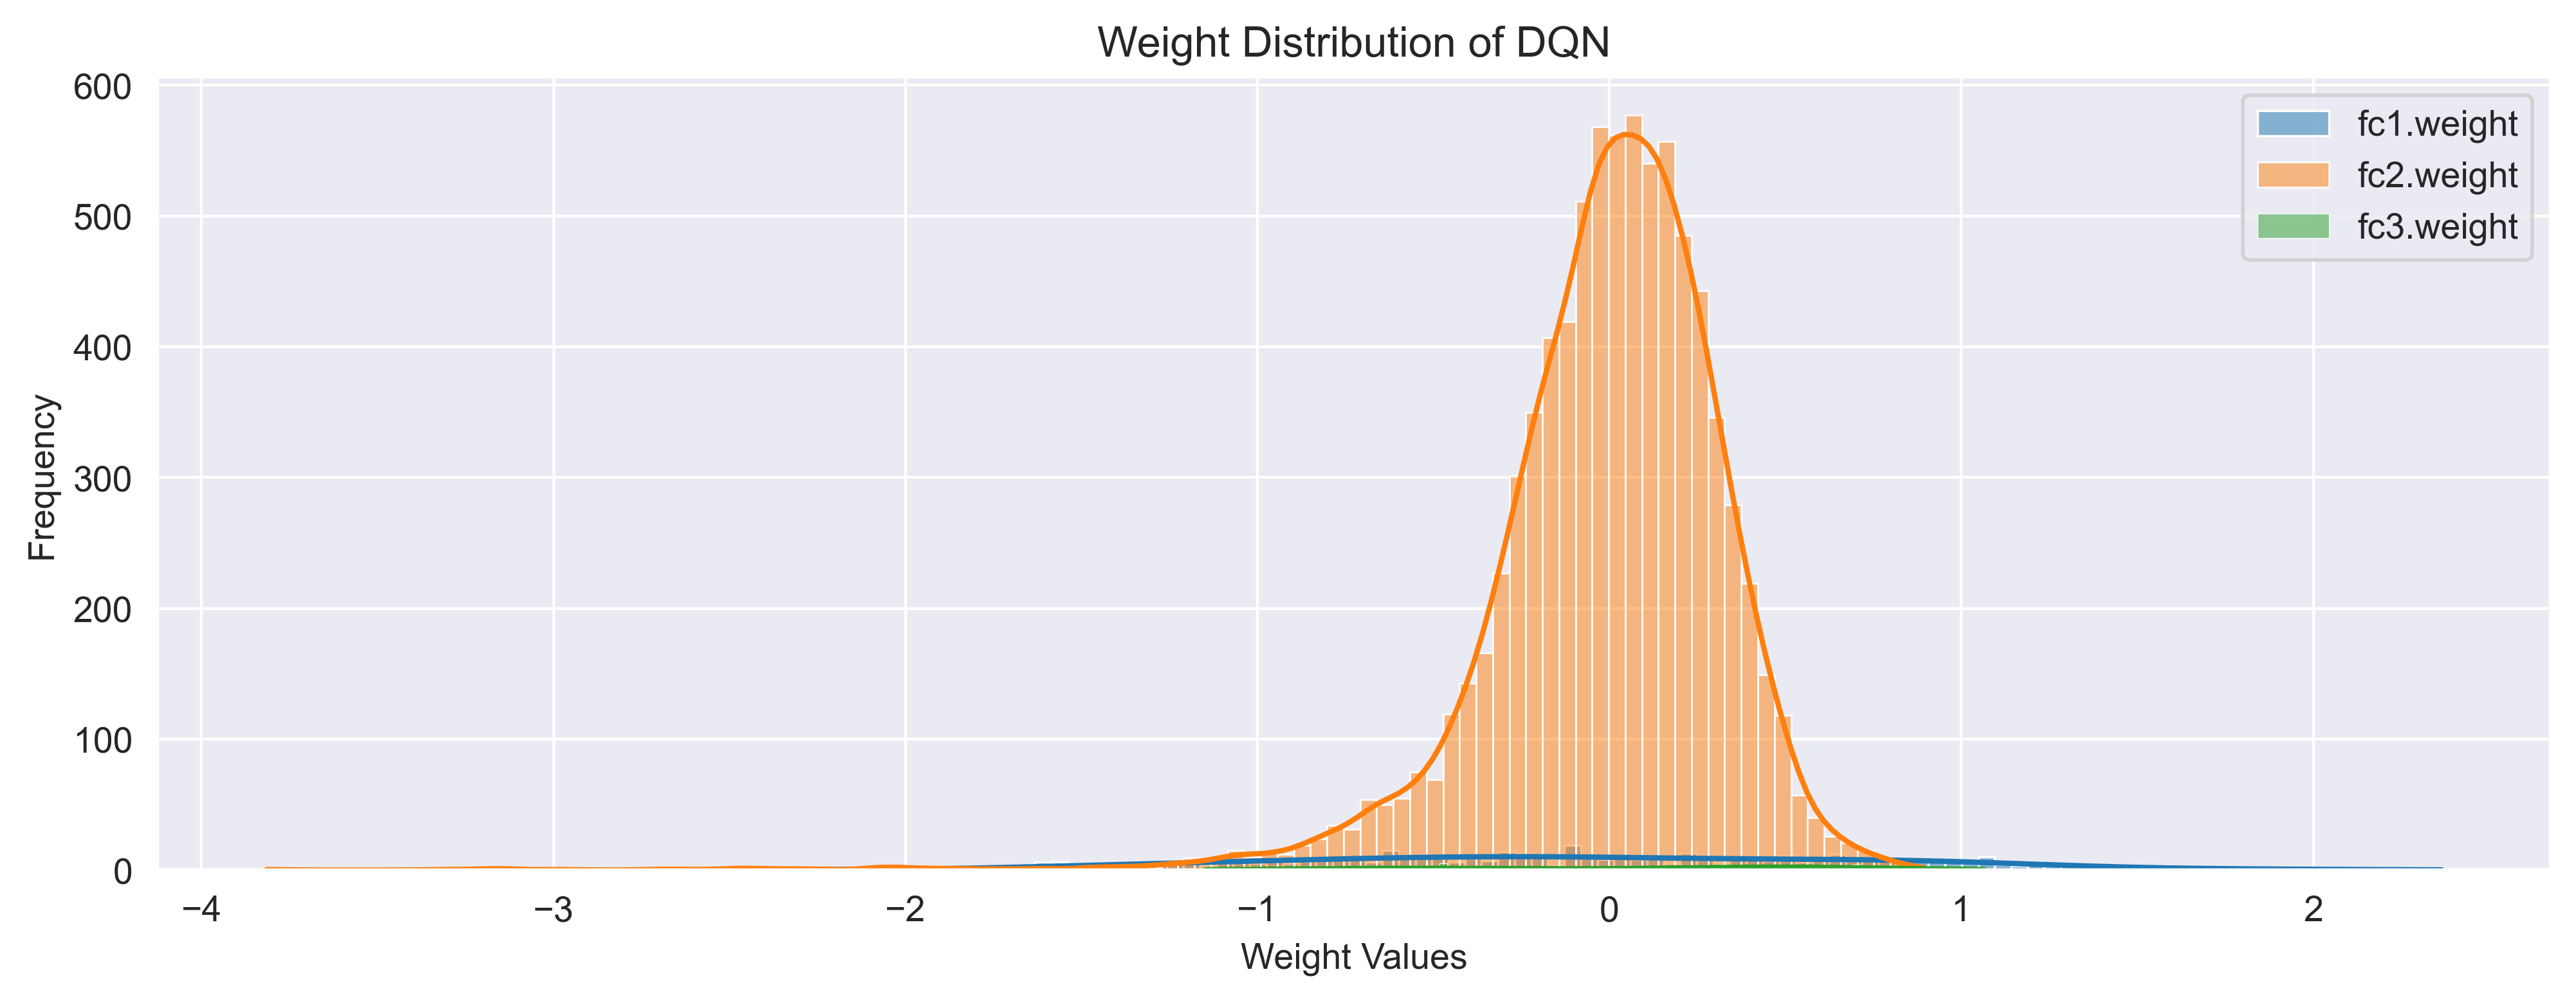

In [5]:
# 현재 policy_net의 가중치 분포 확인
plot_weight_distribution(agent.policy_net)

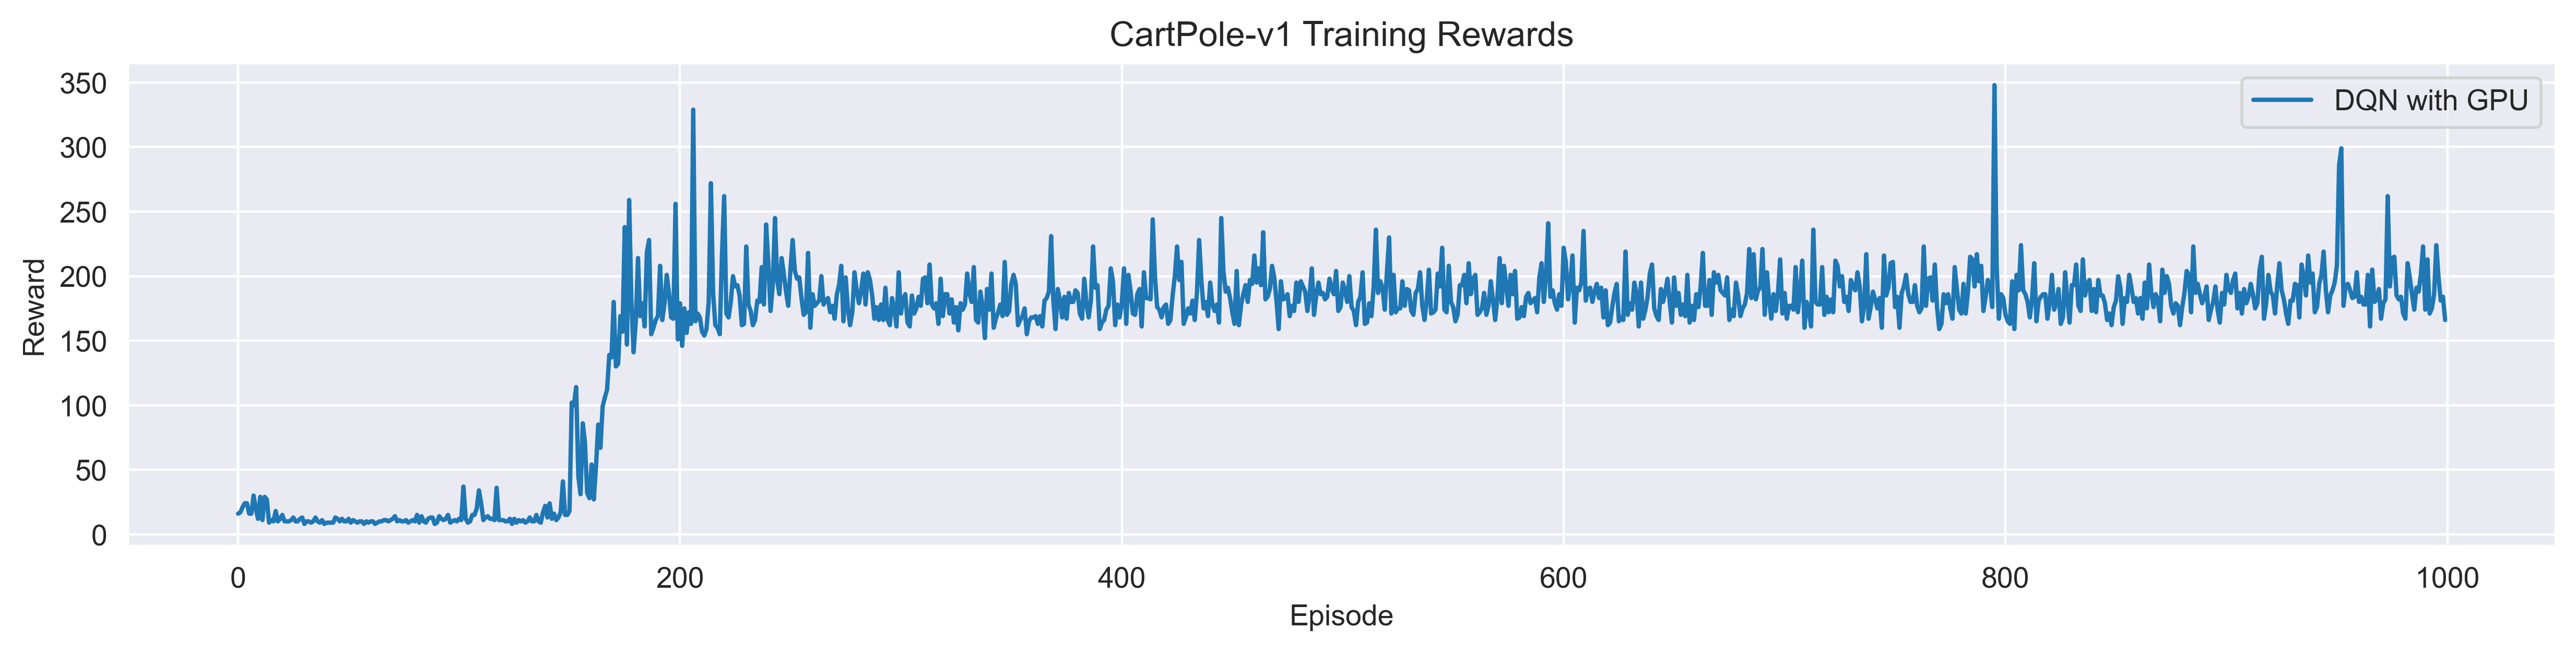

Final epsilon: 0.01
First 10 episode rewards: [16.0, 17.0, 21.0, 24.0, 24.0, 16.0, 16.0, 30.0, 20.0, 12.0]
Last 10 episode rewards: [174.0, 213.0, 171.0, 175.0, 186.0, 224.0, 199.0, 181.0, 184.0, 166.0]
Average reward over last 100 episodes: 191.31


In [6]:
# 학습 결과 시각화
plt.figure(figsize=(15, 3), dpi=400)
plt.plot(rewards_log, label="DQN with GPU")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("CartPole-v1 Training Rewards")
plt.legend()
plt.show()

print(f"Final epsilon: {agent.epsilon}")
print("First 10 episode rewards:", rewards_log[:10])
print("Last 10 episode rewards:", rewards_log[-10:])
print(f"Average reward over last 100 episodes: {np.mean(rewards_log[-100:]):.2f}")